In [301]:
using WAV
using Plots
using DSP
using FFTW
using LinearAlgebra

In [3]:
master, fs = wavread("./wav.wav")

([-0.0009155552842799158; -0.000946073793755913; … ; 0.0006714072084719382; 0.000946073793755913], 44100.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x44, 0xac, 0x00, 0x00, 0x88, 0x58, 0x01, 0x00, 0x02, 0x00, 0x10, 0x00])])

In [4]:
master

105399×1 Matrix{Float64}:
 -0.0009155552842799158
 -0.000946073793755913
 -0.0007324442274239326
 -0.0006714072084719382
 -0.000793481246375927
 -0.0007324442274239326
 -0.0006103701895199438
 -0.0006103701895199438
 -0.0007324442274239326
 -0.0006714072084719382
 -0.000640888698995941
 -0.0007019257179479354
 -0.0006103701895199438
  ⋮
  0.0007324442274239326
  0.0007324442274239326
  0.0007324442274239326
  0.0006714072084719382
  0.000793481246375927
  0.0007324442274239326
  0.000793481246375927
  0.000640888698995941
  0.0006714072084719382
  0.0006103701895199438
  0.0006714072084719382
  0.000946073793755913

In [6]:
length(master)

105399

In [7]:
fs

44100.0f0

In [15]:
t = range(0, length(master)/fs; step=1/fs)

0.0f0:2.2675737f-5:2.3899999f0

In [23]:
center = Int(floor(length(master)/2))

52699

In [24]:
cuttime = 0.04

0.04

In [49]:
x = master[Int(center - cuttime / 2 * fs):Int(center + cuttime / 2 * fs)];

In [29]:
time = t[Int(center - cuttime / 2 * fs):Int(center + cuttime / 2 * fs)];

In [34]:
length(time)

1765

In [31]:
length(x)

1765

In [32]:
Int(center - cuttime / 2 * fs)

51817

In [33]:
Int(center + cuttime / 2 * fs)

53581

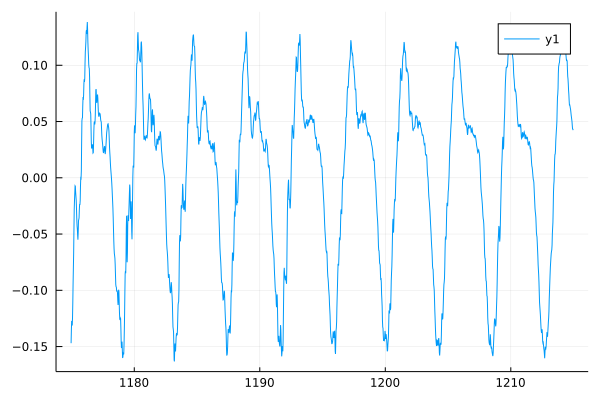

In [37]:
plot(time * 1000, x)

In [45]:
hamming_fn = hamming(length(x));

In [50]:
x = x .* hamming_fn;

In [111]:
length(time)

1765

In [112]:
N = 1765

1765

In [113]:
spec = abs.(fft(x))[1:Int(floor(N/2))];

In [114]:
fscale = FFTW.fftfreq(N, fs)[1:Int(floor(N/2))];

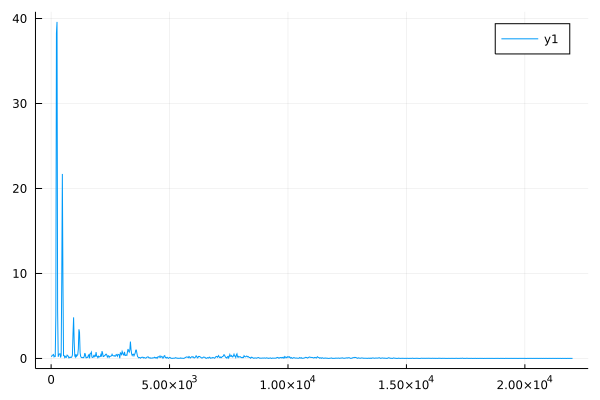

In [115]:
plot(fscale, spec)

In [77]:
function hz2mel(f)
    return 2595 * log(f / 700 + 1.0)
end

hz2mel (generic function with 1 method)

In [85]:
function mel2hs(m)
    return 700 .* (exp.(m ./ 2595) .- 1.0)
end

mel2hs (generic function with 1 method)

## メルフィルタバンク

In [76]:
fmax = fs / 2

22050.0f0

In [126]:
melmax = hz2mel(fmax)

9033.81803182612

In [272]:
nmax = floor(N/2)

882.0

In [273]:
df = fs / N

24.985836f0

In [274]:
dmel = melmax / (21)

430.18181103933904

In [275]:
melcenters = range(1, 21; step=1) .* dmel

430.18181103933904:430.18181103933904:9033.81803182612

In [276]:
fcenters = mel2hs(melcenters);

In [277]:
indexcenter = round.(fcenters ./ df);

In [278]:
length(indexcenter)

21

In [279]:
indexcenter[1]

5.0

In [280]:
indexstart = append!([1], indexcenter[1:20])

21-element Vector{Int64}:
   1
   5
  11
  18
  26
  36
  48
  61
  78
  97
 119
 146
 177
 214
 257
 309
 369
 441
 526
 626
 743

In [281]:
indexstop = append!(indexcenter[2:end], [nmax])

21-element Vector{Float64}:
  11.0
  18.0
  26.0
  36.0
  48.0
  61.0
  78.0
  97.0
 119.0
 146.0
 177.0
 214.0
 257.0
 309.0
 369.0
 441.0
 526.0
 626.0
 743.0
 882.0
 882.0

In [282]:
indexcenter

21-element Vector{Float64}:
   5.0
  11.0
  18.0
  26.0
  36.0
  48.0
  61.0
  78.0
  97.0
 119.0
 146.0
 177.0
 214.0
 257.0
 309.0
 369.0
 441.0
 526.0
 626.0
 743.0
 882.0

In [283]:
filterbank = zeros(21, Int(nmax));
for c in range(1, 21; step=1)
    increment = 1.0 / (indexcenter[c] - indexstart[c])
    for i in range(Int(indexstart[c]), Int(indexcenter[c]); step=1)
        filterbank[c, i] = (i - indexstart[c]) * increment
    end
    decrement = 1.0 / (indexstop[c] - indexcenter[c])
#     println(indexstop[c] - indexcenter[c])
    for i in range(Int(indexcenter[c]), Int(indexstop[c]); step=1)
        filterbank[c, i] = 1.0 - ((i - indexcenter[c]) * decrement)
#         println(1.0 - ((i - indexcenter[c]) * decrement))
        if isnan(filterbank[c, i])
#             println("$(i), $(indexstop[c]), $(indexcenter[c]))")
            filterbank[c, i] = 1.0
        end
    end
end

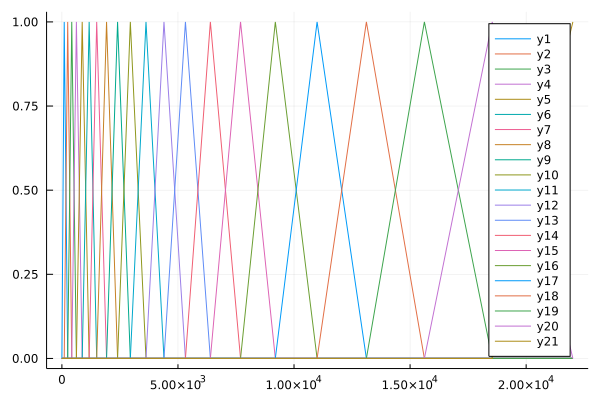

In [287]:
plot(range(0, N/2-1; step=1) * df, filterbank[1, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[2, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[3, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[4, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[5, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[6, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[7, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[8, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[9, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[10, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[11, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[12, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[13, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[14, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[15, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[16, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[17, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[18, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[19, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[20, :])
plot!(range(0, N/2-1; step=1) * df, filterbank[21, :])
# plot!(range(0, N/2-1; step=1) * df, filterbank[2, :])
# for c in range(2, 21; step=1)
#     plot!(range(0, N/2-1; step=1) * df, filterbank[c, :])
# end

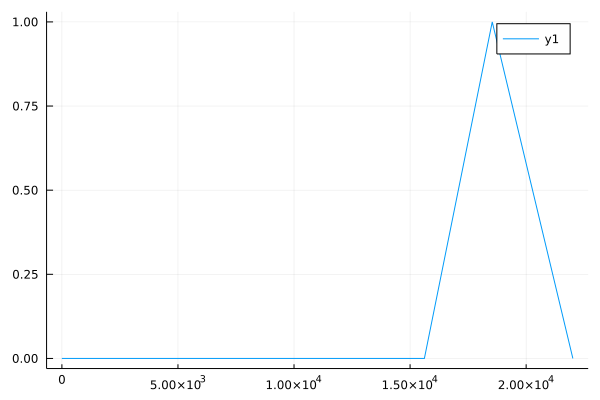

In [316]:
plot(range(0, N/2-1; step=1) * df, filterbank[20, :])

In [173]:
size(filterbank[1, :])

(882,)

In [172]:
range(0, N/2; step=1)

0.0:1.0:882.0

In [308]:
mspec = filterbank * spec

21-element Vector{Float64}:
  9.558041644989597
 80.73636141955933
 32.63798129747976
 11.750675839031897
  9.359478212552432
 12.258220473710503
  4.270942197259461
  5.879228885385206
  6.840899979671144
 12.841689323723957
 11.602769959162393
  3.7770689480597506
  3.406513635408159
  6.26940001481102
 10.548977435727414
  5.217532642654417
  5.60660459457888
  3.788690000917588
  1.9914638474503867
  1.315594579746585
  0.5819073629075251

In [288]:
size(spec)

(882,)

In [289]:
size(filterbank)

(21, 882)

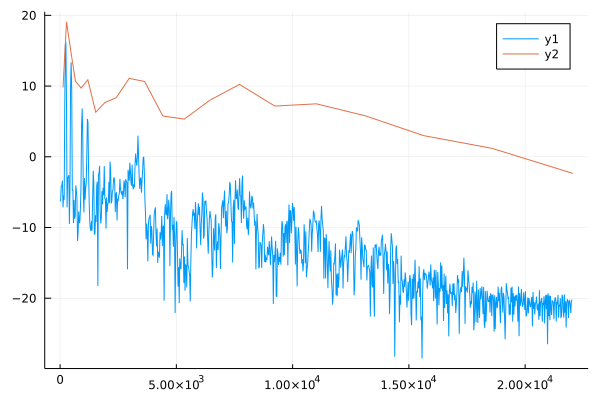

In [310]:
plot(fscale, 10 * log10.(spec))
plot!(fcenters, 10 * log10.(mspec))

In [299]:
size(fcenters)

(21,)

In [303]:
size(spec)

(882,)

In [305]:
size(filterbank)

(21, 882)

In [313]:
ceps = dct(10 * log10.(mspec))

21-element Vector{Float64}:
 37.30816355636851
 15.038431649814608
 -1.3045960638152996
  8.227474323172503
 -2.0139342170632633
  3.9523287958333677
 -3.8177072960036686
 -3.5989514878012203
 -0.8141040820702073
  1.0700921440941848
 -4.847713658485811
 -4.5508572470485005
 -2.0376773082420594
 -2.5482027361899666
 -3.140079625006989
 -0.05032805964233619
 -0.8127893672281308
  0.47864746530732205
 -1.14409077256105
 -2.089156318972232
 -0.46079679809334045

In [314]:
mfcc = ceps[1:12]

12-element Vector{Float64}:
 37.30816355636851
 15.038431649814608
 -1.3045960638152996
  8.227474323172503
 -2.0139342170632633
  3.9523287958333677
 -3.8177072960036686
 -3.5989514878012203
 -0.8141040820702073
  1.0700921440941848
 -4.847713658485811
 -4.5508572470485005